# 모델 이해하기

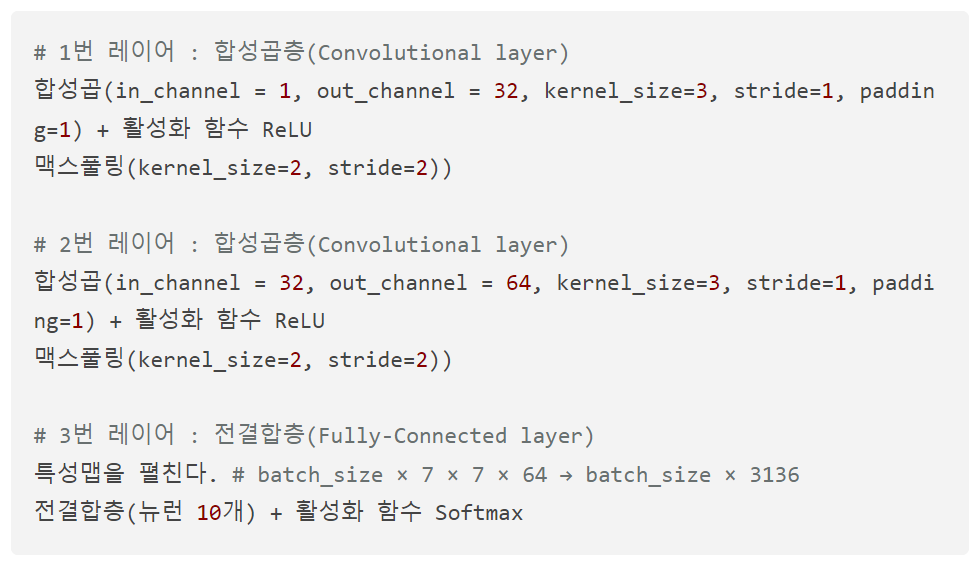

합성곱 층(합성곱 연산을 통해서 이미지의 특징을 추출): 합성곱(nn.Conv2d) + 활성화 함수(nn.ReLU) + 맥스풀링(nn.MaxPoold2d)

- 합성곱(nn.Conv2d): 가중치로 구성된 커널 행렬로 특정 스트라이드를 가지고 이미지 행렬을 훑으면서 이미지의 특징(특성 맵) 추출. 편향은 하나의 값만 존재하며 커널이 적용된 결과의 모든 원소에 더함. 특성 맵의 크기가 입력의 크기와 동일하게 유지되도록 하고 싶다면 패딩 사용. (데이터의 채널 수와 커널의 채널 수는 같아 합성곱 연산을 채널마다 수행해 각각 특성 맵을 얻으며 모두 더해 최종 특성 맵을 얻음)
- 활성화 함수(nn.ReLU): 비선형성 추가
- 맥스풀링(nn.MaxPoold2d): 커널과 스트라이드를 가지고 특성 맵의 크기를 줄이는 연산

<힌 개의 커널을 사용한 3차원 텐서의 합성곱>  
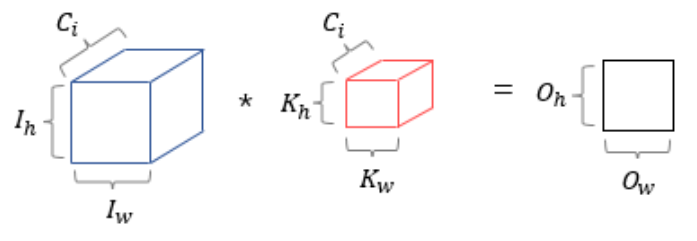    
<여러 개의 커널을 사용한 3차원 텐서의 합성곱> 
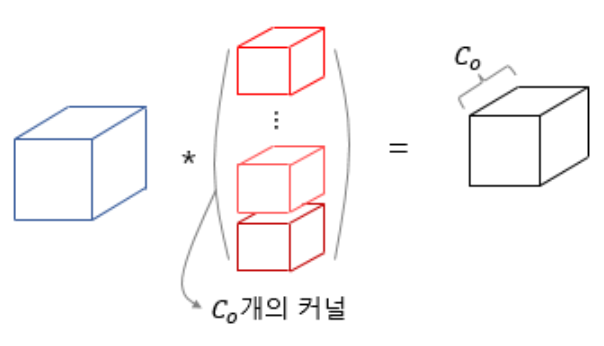   

# 모델 구현하기

In [7]:
import torch
import torch.nn as nn

# 배치 크기 × 채널 × 높이(height) × 너비(widht)의 크기의 텐서를 선언
inputs = torch.Tensor(1, 1, 28, 28)

conv1 = nn.Conv2d(1, 32, 3, padding=1) # in_channels=1, out_channels=32
out = conv1(inputs)
print(out.shape)
pool = nn.MaxPool2d(2) # kernel_size=2, stride=2
out = pool(out)
print(out.shape)
conv2 = nn.Conv2d(32, 64, 3, padding=1) # in_channels=32, out_channels=64
out = conv2(out)
print(out.shape)
pool = nn.MaxPool2d(2) # kernel_size=2, stride=2
out = pool(out)
print(out.shape)

# 첫번째 차원인 배치 차원은 그대로 두고 나머지는 펼쳐라
out = out.view(out.size(0), -1) 
print(out.shape)

fc = nn.Linear(3136, 10) # 전결합층(Fully-Connteced layer) / input_dim = 3,136, output_dim = 10
out = fc(out)
print(out.shape)

torch.Size([1, 32, 28, 28])
torch.Size([1, 32, 14, 14])
torch.Size([1, 64, 14, 14])
torch.Size([1, 64, 7, 7])
torch.Size([1, 3136])
torch.Size([1, 10])


# CNN으로 MNIST 분류하기

In [10]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# 하이퍼파라미터 고정
learning_rate = 0.001
training_epochs = 15
batch_size = 100

# 데이터
mnist_train = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)


class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        # ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 두번째층
        # ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out

# CNN 모델 정의
model = CNN().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_batch = len(data_loader)

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y느 ㄴ레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.225650638
[Epoch:    2] cost = 0.0630516708
[Epoch:    3] cost = 0.0462231413
[Epoch:    4] cost = 0.0374182053
[Epoch:    5] cost = 0.0312010683
[Epoch:    6] cost = 0.0261333473
[Epoch:    7] cost = 0.0217183381


In [ ]:
# 학습을 진행하지 않을 것이므로 torch.no_grad()
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

c:\Users\82105\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\Users\82105\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.22869999706745148
